# Практическое задание 2 (часть 2)

# Распознавание именованных сущностей из Twitter с помощью LSTM

## курс "Математические методы анализа текстов"


### ФИО: АМИНОВ ТИМУР ВЕНЕРОВИЧ


## Введение

### Постановка задачи

В этом задании вы будете использовать рекуррентные нейронные сети для решения проблемы распознавания именованных сущностей (NER). Примерами именованных сущностей являются имена людей, названия организаций, адреса и т.д. В этом задании вы будете работать с данными twitter.

Например, вы хотите извлечь имена и названия организаций. Тогда для текста

    Yan Goodfellow works for Google Brain

модель должна извлечь следующую последовательность:

    B-PER I-PER    O     O   B-ORG  I-ORG

где префиксы *B-* и *I-* означают начало и конец именованной сущности, *O* означает слово без тега. Такая префиксная система введена, чтобы различать последовательные именованные сущности одного типа.

Решение этого задания будет основано на нейронных сетях, а именно на Bi-Directional Long Short-Term Memory Networks (Bi-LSTMs).

### Библиотеки

Для этого задания вам понадобятся следующие библиотеки:
 - [Pytorch](https://pytorch.org/).
 - [Numpy](http://www.numpy.org).
 
### Данные

Все данные содержатся в папке `./data`: `./data/train.txt`, `./data/validation.txt`, `./data/test.txt`.

Скачать архив можно здесь: [ссылка на google диск](https://drive.google.com/open?id=1s1rFOFMZTBqtJuQDcIvW-8djA78iUDcx)

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

## Часть 1. Подготовка данных (2 балла)

### Загрузка данных

Мы будем работать с данными, которые содержат твиты с тегами именованных сущностей. Каждая строка файла содержит пару токен(слово или пунктуация) и тег, разделенные пробелом. Различные твиты разделены пустой строкой.

Функция *read_data* считывает корпус из *file_path* и возвращает два списка: один с токенами и один с соответствующими токенам тегами. Также она заменяет все ники (токены, которые начинаются на символ *@*) на токен `<USR>` и url-ы (токены, которые начинаются на *http://* или *https://*) на токен `<URL>`. 

Вам необходимо реализовать эту функцию.

In [2]:
def read_data(file_path):
    tokens = []
    tags = []
    tok_1 = []
    tag_1 = []
    
    f=open(file_path,"r",encoding="utf-8" )
    for line in f:
        spi = line.split()
        if(len(spi) == 2):
            tok , tag = spi
            if (tok[0] is '@'):
                tok = '<USR>'
                

            if (tok.find('http://') + 1):
                tok = '<URL>'
            if (tok.find('https://') + 1):
                tok = '<URL>'
                
            tok_1.append(tok)
            tag_1.append(tag)
        elif(len(spi) == 0):
            #print(tok_1)
            tokens.append(tok_1)
            tags.append(tag_1)
            #tokens.insert(0,tok_1)
            tok_1 = []
            tag_1 = []
        
    return tokens, tags

In [3]:
line  = []
pil = ['1' ,'1' ,' 1']
line.append(pil)
line.append(pil)
pil= []
line.append(pil)
line

[['1', '1', ' 1'], ['1', '1', ' 1'], []]

In [4]:
train_tokens, train_tags = read_data('data/train_1.txt')

In [5]:
train_tokens

[['RT',
  '<USR>',
  ':',
  'Online',
  'ticket',
  'sales',
  'for',
  'Ghostland',
  'Observatory',
  'extended',
  'until',
  '6',
  'PM',
  'EST',
  'due',
  'to',
  'high',
  'demand',
  '.',
  'Get',
  'them',
  'before',
  'they',
  'sell',
  'out',
  '...'],
 ['Apple',
  'MacBook',
  'Pro',
  'A1278',
  '13.3',
  '"',
  'Laptop',
  '-',
  'MD101LL/A',
  '(',
  'June',
  ',',
  '2012',
  ')',
  '-',
  'Full',
  'read',
  'by',
  'eBay',
  '<URL>',
  '<URL>']]

In [6]:
train_tags

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-musicartist',
  'I-musicartist',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['B-product',
  'I-product',
  'I-product',
  'I-product',
  'I-product',
  'I-product',
  'I-product',
  'I-product',
  'I-product',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-company',
  'O',
  'O']]

Теперь мы можем загрузить 3 части данных:
 - *train* для тренировки модели;
 - *validation* для валидации и подбора гиперпараметров;
 - *test* для финального тестирования.

In [7]:
train_tokens, train_tags = read_data('data/train.txt')
validation_tokens, validation_tags = read_data('data/validation.txt')
test_tokens, test_tags = read_data('data/test.txt')

In [8]:
train_tokens[0]

['RT',
 '<USR>',
 ':',
 'Online',
 'ticket',
 'sales',
 'for',
 'Ghostland',
 'Observatory',
 'extended',
 'until',
 '6',
 'PM',
 'EST',
 'due',
 'to',
 'high',
 'demand',
 '.',
 'Get',
 'them',
 'before',
 'they',
 'sell',
 'out',
 '...']

In [9]:
train_tags[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-musicartist',
 'I-musicartist',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

Всегда полезно знать, с какими данными вы работаете. Выведем небольшую часть.

In [10]:
for i in range(3):
    for token, tag in zip(train_tokens[i], train_tags[i]):
        print('%s\t%s' % (token, tag))
    print()

RT	O
<USR>	O
:	O
Online	O
ticket	O
sales	O
for	O
Ghostland	B-musicartist
Observatory	I-musicartist
extended	O
until	O
6	O
PM	O
EST	O
due	O
to	O
high	O
demand	O
.	O
Get	O
them	O
before	O
they	O
sell	O
out	O
...	O

Apple	B-product
MacBook	I-product
Pro	I-product
A1278	I-product
13.3	I-product
"	I-product
Laptop	I-product
-	I-product
MD101LL/A	I-product
(	O
June	O
,	O
2012	O
)	O
-	O
Full	O
read	O
by	O
eBay	B-company
<URL>	O
<URL>	O

Happy	O
Birthday	O
<USR>	O
!	O
May	O
Allah	B-person
s.w.t	O
bless	O
you	O
with	O
goodness	O
and	O
happiness	O
.	O



### Подготовка словарей

Чтобы обучать нейронную сеть, мы будем использовать два отображения.

- {token}$\to${token id}: устанавливает соответствие между токеном и строкой в embedding матрице;
- {tag}$\to${tag id}: one hot encoding тегов.


Теперь вам необходимо реализовать функцию *build_dict*, которая должна возвращать словарь {token or tag}$\to${index} и контейнер, задающий обратное отображение.

In [11]:
from collections import defaultdict

In [12]:
def build_dict(tokens_or_tags, special_tokens):
    """
        tokens_or_tags: a list of lists of tokens or tags
        special_tokens: some special tokens
    """
    # Create a dictionary with default value 0
    tok2idx = defaultdict(lambda: 0)
    idx2tok = []
    idx = 0
    
    for token in special_tokens:
        tok2idx[token] = idx
        idx2tok.append(token)
        idx += 1
    for message in tokens_or_tags:
        for token in message:
            if token not in tok2idx:
                tok2idx[token] = idx
                idx2tok.append(token)
                idx += 1 


    return tok2idx, idx2tok

После реализации функции *build_dict* вы можете создать словари для токенов и тегов. В нашем случае специальными токенами будут:
 - `<UNK>` токен для обозначаения слов, которых нет в словаре;
 - `<PAD>` токен для дополнения предложений одного батча до одинаковой длины.

In [13]:
special_tokens = ['<UNK>', '<PAD>']
special_tags = ['O']

# Create dictionaries 
token2idx, idx2token = build_dict(train_tokens + validation_tokens, special_tokens)
tag2idx, idx2tag = build_dict(train_tags, special_tags)

In [14]:
train_idxs = []
train_tag_idxs = []
for i in range(len(train_tokens)):
    train_idxs.append([])
    train_tag_idxs.append([])
    for j in range(len(train_tokens[i])):
        train_idxs[i].append(token2idx[train_tokens[i][j]])
        train_tag_idxs[i].append(tag2idx[train_tags[i][j]])

In [15]:
test_idxs = []
test_tag_idxs = []
for i in range(len(test_tokens)):
    test_idxs.append([])
    test_tag_idxs.append([])
    for j in range(len(test_tokens[i])):
        test_idxs[i].append(token2idx[test_tokens[i][j]])
        test_tag_idxs[i].append(tag2idx[test_tags[i][j]])

### Генератор батчей

Обычно нейронные сети обучаются батчами. Это означает, что каждое обновление весов нейронной сети происходит на основе нескольких последовательностей. Технической деталью является необходимость дополнить все последовательности внутри батча до одной длины. Для некоторых фреймворков (таких как tensorflow) это необходимо сделать до подачи батча в нейронную сеть. В случае с pytorch это можно сделать как вне архитектуры нейронной сети, так и внутри. Мы выбрали более универсальный вариант и наш генератор батчей дополняет все последовательности внутри одного батча до одной длины.

Генератор батчей разбивает последовательность входных предложений и тегов на батчи размера batch_size. Размер последнего батча может быть меньше, если allow_smaller_last_batch is True, иначе последний батч исключается из генератора. Если включён параметр shuffle, данные перед разделением на батчи будут перемешаны. 

In [16]:
def batches_generator(batch_size, tokens_idxs, tags_idxs,
                      shuffle=True, allow_smaller_last_batch=True, device='cpu'):
    """
    Generates padded batches of tags_idxs and tags_idxs.
    
    batch_size : int, number of objects in one batch
    tokens_idxs : list of list of int
    tags_idxs : list of list of int
    shuffle : bool
    allow_smaller_last_batch : bool
    device: str, cpu or cuda:x
    
    yield x, y: torch.LongTensor and torch.LongTensor
    x - batch of tokens_idxs, y - batch of tags_idxs
    """
    n_samples = len(tokens_idxs)
    idxs = np.arange(n_samples)
    
    # Shuffle data if shuffle is True.
    # Don't modify the original tokens and tags!
    
    if(shuffle):
        np.random.shuffle(idxs)
    
    # Get the number of batches
    # n_batches 
    
    if allow_smaller_last_batch:
        n_batches = n_samples // batch_size 
        n_batches += 1 if n_samples % n_batches else 0
    else:
        n_batches = n_samples // batch_size
    
    
    
    
    # For each k yield pair x and y
    for k in range(n_batches):
        if (k + 1) * batch_size > n_samples:
            batch_idxs = idxs[k * batch_size:]
            batch_size = n_samples - k * batch_size
        else:
            batch_idxs = idxs[k * batch_size: (k + 1) * batch_size]
        
        max_len = max([len(tokens_idxs[i]) for i in batch_idxs])
        x = torch.ones((batch_size,max_len))
        y = torch.zeros((batch_size,max_len))
        for i in range(batch_size):
            for j in range(len(tokens_idxs[batch_idxs[i]])):
                x[i,j] = tokens_idxs[batch_idxs[i]][j]
                y[i,j] = tags_idxs[batch_idxs[i]][j]      
        
        x = x.long().to(device)
        y = y.long().to(device)
        
        yield x, y

Протестируйте ваш генератор батчей:

In [17]:
test_nonrandom_batch_generator = batches_generator(
    batch_size=3,
    tokens_idxs=train_idxs[:7],
    tags_idxs=train_tag_idxs[:7],
    shuffle=False,
    allow_smaller_last_batch=True
)

batch_lengths = [3, 3, 1]
sequence_lengths = [26, 25, 8]
some_pad_tensor = torch.LongTensor([token2idx['<PAD>']] * 12)
some_outside_tensor = torch.LongTensor([tag2idx['O'] * 12])

for i, (tokens_batch, tags_batch) in enumerate(test_nonrandom_batch_generator):
    assert tokens_batch.dtype == torch.int64, 'tokens_batch is not LongTensor'
    assert tags_batch.dtype == torch.int64, 'tags_batch is not LongTensor'
    
    assert len(tokens_batch) == batch_lengths[i], 'wrong batch length'
    
    for one_token_sequence in tokens_batch:
        assert len(one_token_sequence) == sequence_lengths[i], 'wrong length of sequence in batch'
    
    if i == 0:
        assert torch.all(tokens_batch[2][-12:] == some_pad_tensor), "wrong padding"       
        assert torch.all(tags_batch[2][-12:] == some_outside_tensor), "wrong O tag"

## Часть 2. BiLSTM (3 балла)

Определите архитектуру сети, используя библиотеку pytorch. 

**Замечания:**
1. Для улучшения качества сети предлагается использовать дополнительный Embedding слой на входе (каждому слову ставится в соответствие обучаемый вектор). 

2. Не забудьте, что `<PAD>` токены не должны учавствовать в подсчёте функции потерь.

In [112]:
class BiLSTMModel(torch.nn.Module):
    def __init__(self, vocabulary_size, n_tags, PAD_index,
                 embedding_dim, rnn_hidden_size,
                 dropout_zeroed_probability,
                 device='cpu'):
        '''
        Defines neural network structure.
        
        architecture: input -> Embedding -> BiLSTM -> Dropout -> Linear
        optimizer: Adam
        
        ----------
        Parameters
        
        vocabulary_size: int, number of words in vocabulary.
        n_tags: int, number of tags.
        PAD_index: int, index of padding character. Used for loss masking.
        embedding_dim: int, dimension of words' embeddings.
        rnn_hidden_size: int, number of hidden units in each LSTM cell
        dropout_zeroed_probability: float, dropout zeroed probability for Dropout layer.
        device: str, cpu or cuda:x
        '''
        super(BiLSTMModel, self).__init__()        
        self.embedding = nn.Embedding(vocabulary_size,embedding_dim,)
        self.lstm = nn.LSTM(embedding_dim, rnn_hidden_size,bidirectional=True,batch_first=True)
        self.hidden2tag = nn.Linear(2*rnn_hidden_size,n_tags)
        self.dropout = nn.Dropout(dropout_zeroed_probability) 
    def forward(self, x_batch):
        '''
        Makes forward pass.
        
        ----------
        Parameters
        x_batch: torch.LongTensor with shape (number of samples in batch, number words in sentence).
        '''
        cod_batch = self.embedding(x_batch)
        lstm_out, _ = self.lstm(cod_batch)
        lstm_out = self.dropout(lstm_out)
        return self.hidden2tag(lstm_out)       
    
    def predict_for_batch(self, x_batch):
        '''
        Returns predictions for x_batch.
        
        return type: torch.LongTensor
        return shape: (number of samples in batch, number words in sentence.
        
        ----------
        Parameters
        x_batch: torch.LongTensor with shape (number of samples in batch, number words in sentence).
        '''
        self.eval()
        with torch.no_grad():
            f_batch = self.forward(x_batch)
        self.train()
        return f_batch.argmax(dim=2)        
    
                          
    def train_on_batch (self, x_batch, y_batch, optimizer, loss_function):
        '''
        Trains model on the given batch.
        
        ----------
        Parameters
        x_batch: np.ndarray with shape (number of samples in batch, number words in sentence).
        y_batch: np.ndarray with shape (number of samples in batch).
        optimizer: torch.optimizer class
        loss_function: torch loss class
        '''
        optimizer.zero_grad()
        y = model.forward(x_batch).max(dim=2)[0]
        loss = loss_function(y,y_batch)
        loss.backward()
        optimizer.step()
        return loss.item()       


Для тестирования сети мы подготовили для вас две функции:
 - *predict_tags*: получает батч данных и трансформирует его в список из токенов и предсказанных тегов;
 - *eval_conll*: вычисляет метрики precision, recall и F1

In [19]:
from evaluation_ner import precision_recall_f1

In [20]:
def predict_tags(model, token_idxs_batch):
    """Performs predictions and transforms indices to tokens and tags."""
    
    tag_idxs_batch = model.predict_for_batch(token_idxs_batch)
    tags_batch, tokens_batch = [], []
    for tag_idxs, token_idxs in zip(tag_idxs_batch, token_idxs_batch):
        tags, tokens = [], []
        for tag_idx, token_idx in zip(tag_idxs, token_idxs):
            if token_idx != token2idx['<PAD>']:
                tags.append(idx2tag[tag_idx])
                tokens.append(idx2token[token_idx])
        tags_batch.append(tags)
        tokens_batch.append(tokens)
    return tags_batch, tokens_batch
    
    
def eval_conll(model, tokens, tags, short_report=True):
    """Computes NER quality measures using CONLL shared task script."""
    
    y_true, y_pred = [], []
    for x_batch, y_batch in batches_generator(1, tokens, tags):
        tags_batch, tokens_batch = predict_tags(model, x_batch)
        ground_truth_tags = [idx2tag[tag_idx] for tag_idx in y_batch[0]]

        # We extend every prediction and ground truth sequence with 'O' tag
        # to indicate a possible end of entity.
        y_true.extend(ground_truth_tags + ['O'])
        y_pred.extend(tags_batch[0] + ['O'])
    results = precision_recall_f1(y_true, y_pred, print_results=True, short_report=short_report)
    return results

In [113]:
model= BiLSTMModel(len(token2idx),len(tag2idx),1,200,200,0.1)

In [114]:
eval_conll(model,train_idxs[:500],train_tag_idxs[:500])

processed 9087 tokens with 393 phrases; found: 6937 phrases; correct: 18.

precision:  0.26%; recall:  4.58%; F1:  0.49



OrderedDict([('company',
              OrderedDict([('precision', 0.5115089514066496),
                           ('recall', 5.797101449275362),
                           ('f1', 0.9400705052878967),
                           ('n_predicted_entities', 782),
                           ('n_true_entities', 69)])),
             ('facility',
              OrderedDict([('precision', 0.0),
                           ('recall', 0.0),
                           ('f1', 0),
                           ('n_predicted_entities', 428),
                           ('n_true_entities', 21)])),
             ('geo-loc',
              OrderedDict([('precision', 0.0),
                           ('recall', 0.0),
                           ('f1', 0),
                           ('n_predicted_entities', 214),
                           ('n_true_entities', 73)])),
             ('movie',
              OrderedDict([('precision', 0.0),
                           ('recall', 0.0),
                           ('f1', 0),


### Эксперименты

Задайте BiLSTMModel. Рекомендуемые параметры:
- *batch_size*: 32;
- начальное значение *learning_rate*: 0.01-0.001
- *dropout_zeroed_probability*: 0.7-0.9
- *embedding_dim*: 100-200
- *rnn_hidden_size*: 150-200

Проведите эксперименты на данных. Настраивайте параметры по валидационной выборке, не используя тестовую. Ваше цель — настроить сеть так, чтобы качество модели по F1 мере на валидационной и тестовой выборках было не меньше 0.35. 

Если сеть плохо обучается, попробуйте использовать следующие модификации:
    * используйте gradient clipping
    * на каждой итерации уменьшайте learning rate (например, в 1.1 раз)
    * попробуйте вместо Adam другие оптимизаторы 
    * экспериментируйте с dropout

Сделайте выводы о качестве модели, переобучении, чувствительности архитектуры к выбору гиперпараметров. Оформите результаты экспериментов в виде мини-отчета (в этом же ipython notebook).

In [87]:

    device ='cpu'

class BiLSTMModel(torch.nn.Module):
    def __init__(self, vocabulary_size, n_tags, PAD_index,
                 embedding_dim, rnn_hidden_size,
                 dropout_zeroed_probability,
                 device='cpu'):

In [88]:
# гиперпараметры
batch_size = 32;
learning_rate = 1
dropout_zeroed_probability = 0.7
embedding_dim = 150
rnn_hidden_size = 150

In [116]:
model= BiLSTMModel(len(token2idx),len(tag2idx),1,200,200,0.7)       

In [117]:
device

'cpu'

In [128]:
optimizer = torch.optim.SGD(model.parameters(),lr=1 , momentum=0.7)
#criterion = nn.BCEWithLogitsLoss
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,1, gamma=0.91)

In [129]:
num_epoch = 100
loss = []
for epoch in range(num_epoch):
    loss.append(0.)
    i = 0
    for x_batch, y_batch in batches_generator(32,train_idxs[:400],train_tag_idxs[:400]):
    
        y_batch = y_batch.float()
        #print(y_batch[0][0])
        loss[epoch] += model.train_on_batch(x_batch, y_batch,optimizer,criterion)
        i +=1

    scheduler.step()
    lr = scheduler.optimizer.param_groups[0]['lr']
    print("loss on epoch {} = {} , lr = {}".format(epoch,round(loss[epoch]/i , 5) , round(lr , 5)))

loss on epoch 0 = -1313.54791 , lr = 0.91
loss on epoch 1 = -1020.16504 , lr = 0.8281
loss on epoch 2 = -1188.42942 , lr = 0.75357
loss on epoch 3 = -1254.58205 , lr = 0.68575
loss on epoch 4 = -1426.32766 , lr = 0.62403
loss on epoch 5 = -1533.13505 , lr = 0.56787
loss on epoch 6 = -1574.21891 , lr = 0.51676
loss on epoch 7 = -1818.04578 , lr = 0.47025
loss on epoch 8 = -1806.16994 , lr = 0.42793
loss on epoch 9 = -2154.15102 , lr = 0.38942
loss on epoch 10 = -1968.46854 , lr = 0.35437
loss on epoch 11 = -2097.83903 , lr = 0.32248
loss on epoch 12 = -2217.20727 , lr = 0.29345
loss on epoch 13 = -2267.08835 , lr = 0.26704
loss on epoch 14 = -2366.60061 , lr = 0.24301
loss on epoch 15 = -2437.22015 , lr = 0.22114
loss on epoch 16 = -2491.01243 , lr = 0.20124
loss on epoch 17 = -2606.92173 , lr = 0.18312
loss on epoch 18 = -2792.17506 , lr = 0.16664
loss on epoch 19 = -2642.23201 , lr = 0.15164
loss on epoch 20 = -2723.76933 , lr = 0.138
loss on epoch 21 = -2826.14927 , lr = 0.12558
loss

KeyboardInterrupt: 

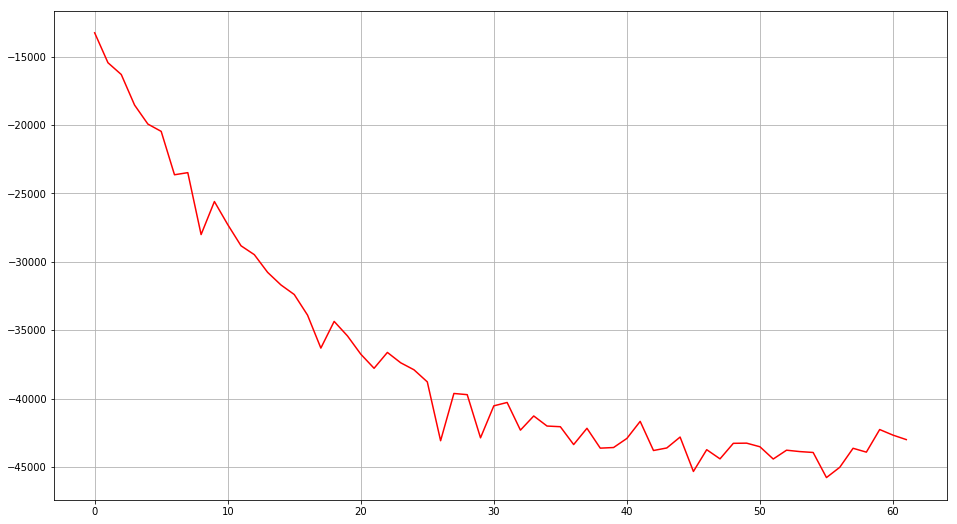

In [131]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,9))
epo =  range(62) 
plt.plot(epo, loss[1:-1] ,color = 'r', label = 'LOSS')

plt.grid()
plt.show()

In [132]:
eval_conll(model,train_idxs[:-400],train_tag_idxs[:-400])

processed 98524 tokens with 4170 phrases; found: 76794 phrases; correct: 54.

precision:  0.07%; recall:  1.29%; F1:  0.13



OrderedDict([('company',
              OrderedDict([('precision', 0.0514668039114771),
                           ('recall', 0.33557046979865773),
                           ('f1', 0.0892458723784025),
                           ('n_predicted_entities', 3886),
                           ('n_true_entities', 596)])),
             ('facility',
              OrderedDict([('precision', 0.0),
                           ('recall', 0.0),
                           ('f1', 0),
                           ('n_predicted_entities', 431),
                           ('n_true_entities', 293)])),
             ('geo-loc',
              OrderedDict([('precision', 0.0),
                           ('recall', 0.0),
                           ('f1', 0),
                           ('n_predicted_entities', 987),
                           ('n_true_entities', 928)])),
             ('movie',
              OrderedDict([('precision', 0.0),
                           ('recall', 0.0),
                           ('f1'

In [133]:
eval_conll(model,test_idxs[:-400],test_tag_idxs[:-400])

processed 5813 tokens with 260 phrases; found: 4590 phrases; correct: 8.

precision:  0.17%; recall:  3.08%; F1:  0.33



OrderedDict([('company',
              OrderedDict([('precision', 0.0),
                           ('recall', 0.0),
                           ('f1', 0),
                           ('n_predicted_entities', 254),
                           ('n_true_entities', 31)])),
             ('facility',
              OrderedDict([('precision', 0.0),
                           ('recall', 0.0),
                           ('f1', 0),
                           ('n_predicted_entities', 39),
                           ('n_true_entities', 24)])),
             ('geo-loc',
              OrderedDict([('precision', 0.0),
                           ('recall', 0.0),
                           ('f1', 0),
                           ('n_predicted_entities', 71),
                           ('n_true_entities', 66)])),
             ('movie',
              OrderedDict([('precision', 0.0),
                           ('recall', 0.0),
                           ('f1', 0),
                           ('n_predicted_entitie

In [ ]:
лучший скор был при SGD и сосотавил f1 = 3

## Бонусная часть. Улучшение качества теггера (4 балла).

Улучшите качество теггера на данной задаче.

Бонусные баллы будут начисляться в зависимости от результата f1-меры (одновременно на тестовой и валидационной выборках!).

+ 1 балл — $> 0.38$
+ 2 балла — $> 0.4$
+ 3 балла — $> 0.425$
+ 4 балла — $> 0.45$

Разрешается использовать любые разумные способы (в том числе и не рассматривающиеся в курсе). Под неразумными способами понимаются любые, в которых используются модели, обученные на dev или test, а также модели, использующие утечки в данных, не относяющиеся к смыслу задачи.